## Install packages

In [1]:
# %pip install torch
# %pip install torchvision
# %pip install matplotlib
# %pip install numpy
# %pip install tqdm
# %pip install psutil
# %pip install gputil

## Imports

In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import numpy as np
import re 
import psutil
import GPUtil

from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
from project.model import VisionTransformer
from torch.optim import Adam
from project.model.fitter import Fitter
from matplotlib import pyplot as plt
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


#### Sets the file number for the ViT weights and Log file

In [3]:
dir_path = 'experiments/'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

#### Sets the logger 

In [4]:
import logging
logger = logging.getLogger('vit')
fh = logging.FileHandler(f'vit_test_logs/vit{file_num + 1}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
logger.propagate = False
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

#### Global Variable

In [5]:
d_model = 16*16
n_classes = 2
img_size = (16,16)
patch_size = (2,2)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.000125

In [6]:
Moddel_info= f'Creating model with d_model={d_model}, n_classes={n_classes}, img_size={img_size}, patch_size={patch_size}, n_channels={n_channels}, n_heads={n_heads}, n_layers={n_layers}, batch_size={batch_size}, epochs={epochs}, alpha={alpha}'
logger.info(Moddel_info)

## Dataset

In [7]:
ds = Dataset()

In [8]:
# masks = ds.load_cmb_masks()
# cases = ds.load_raw_mri()
# cases = ds.load_skullstripped_mri(cohort_num=1)

masks = ds.load_cmb_masks(cohort_num=1)
cases = ds.load_raw_mri(cohort_num=1)

# cases = ds.load_skullstripped_mri()
# masks = ds.load_cmb_masks()

In [9]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [10]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [11]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
11


## Loading the data

In [12]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [13]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [14]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Create ViT

In [16]:
transformer = VisionTransformer(
    D_model=d_model,
    N_classes=n_classes,
    Img_size=img_size,
    Patch_size=patch_size,
    N_channels=n_channels,
    N_heads=n_heads,
    N_layers=n_layers,
    device=device
)

In [17]:
transformer = transformer.to(device)

## Optimizer and Criterion (loss)

In [18]:
optimizer = Adam
criterion = nn.CrossEntropyLoss()

In [19]:
import matplotlib.pyplot as plt
def print_image(img, title):
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.show()

#### Function that monitors GPU usage

In [20]:
def monitor_gpu():
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  Load: {gpu.load * 100}%")
        print(f"  Memory Free: {gpu.memoryFree}MB")
        print(f"  Memory Used: {gpu.memoryUsed}MB")
        print(f"  Temperature: {gpu.temperature}°C")

## Fitter

In [21]:
class ViTFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        for case in train_loader:
            if torch.unique(case[1]).numel() > 1:
                num_slices= len(case[1]) # Number of slices
                case_number = re.search(r'sub-(\d+)', case[2][0]).group(1) # Extract the case number
                # print(f'Case: {case_number}')
                logger.info(f'Training with Case: {case_number}')
                if num_slices != len(case[0]):
                    # print('Not equal Number of slices:', num_slices, data[0]) #Checks if the number of slices of the MRI and the mask are the same
                    logger.error(f'Not equal Number of slices: {num_slices} MRI: {len(case[0])} Mask: {len(data[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(case[1][j][0].numpy()) #Extracts all the bounding boxes of the slice 
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) <= 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logger.warning(f'No bounding boxes found on slice {j}')
                        continue
                    for bbox in bounding_boxes: # For each bounding box it will crop the image and the label based on the given coordinates
                        # print(f"Slice {j} | ", bbox) 
                        logger.info(f'Slice {j} | {bbox}')
                        # print(data[0][j][0].shape)
                        logger.info(f'Image shape: {case[0][j][0].shape}')
                        cropped_images.append(
                            dataset.get_cropped_locations(
                                img = case[0], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        cropped_labels.append(
                            dataset.get_cropped_locations(
                                img = case[1], 
                                x_min=bbox[0],
                                y_min=bbox[1],
                                x_max=bbox[2],
                                y_max=bbox[3]
                            ))
                        coordinates.append(bbox)
                    if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]): ## Checks if the number of cropped images and labels are the same
                        print('Not equal cropped images and labels')
                        logger.error(f'Not equal cropped images and labels')    
                        break

                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                    # print('Cropped Images length:', len(cropped_images))
                    # print('Cropped Labels length:', len(cropped_labels))
                    # print('Cropped Images number of slices:', len(cropped_images[0][0][0])) # This is the MRI image of the CMB with the coordinate
                    # print('Cropped Labels number of slices:', len(cropped_labels[0][0])) # This is the mask of the CMB with the coordinate
                    logger.info(f'Cropped Images length: {len(cropped_images)}')
                    logger.info(f'Cropped Labels length: {len(cropped_labels)}')
                    logger.info(f'Cropped Images number of slices: {len(cropped_images[0][0][0])}')
                    logger.info(f'Cropped Labels number of slices: {len(cropped_labels[0][0])}')
                    for k, cmb in enumerate(cropped_labels[0]): # Access the CMB labels array the n checks if there are CMBs on the slice of the case 
                         for l, cmb_slice in enumerate(cmb):
                            # print(cmb_slice.shape)
                            if torch.unique(cmb_slice).numel() > 1:
                                # print('Multiple classes found on silce: ', l)
                                # print(cmb_slice.shape)
                                # print(cropped_images[0][0][0][l].shape)
                                logger.info(f'Multiple classes found on slice: {l}')
                                logger.info(f'Mask shape: {cmb_slice.shape}')
                                logger.info(f'Image shape: {cropped_images[0][0][0][l].shape}')
                                # Enable ths method to visually see what is feeded on the model 
                                # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                # print(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                logger.info(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                self.optimizer.zero_grad()
                                inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                # print("Feeded inputs shape: ",inputs.shape)
                                # print("Feeded mask shape: ",labels.shape)
                                logger.info(f'Feeded inputs shape: {inputs.shape}')
                                logger.info(f'Feeded mask shape: {labels.shape}')
                                outputs = transformer(inputs.float(), labels.float())
                                loss = criterion(outputs, labels.long())  
                                # print("Output shape: ",outputs.shape)
                                logger.info(f'Output shape: {outputs.shape}')
                                loss.backward()
                                self.optimizer.step()
                                loss_history.append(loss.item())
                                logger.info(f'Loss: {loss.item()}')
                print("Training Loss: ", loss_history[-1]) # Prints the last loss of the epoch
                print("[Training] | CPU Usage: ", psutil.cpu_percent(), '%') # Prints the CPU usage
                print("[Training] | Memory Usage: ", psutil.virtual_memory().percent, '%') # Prints the memory usage
                print("[Training] | GPU Usage: ") # Prints the GPU usage
                monitor_gpu()
            else:
                # print('Skipping case with no CMBs')
                logger.warning('Skipping case with no CMBs')
                continue
        return loss_history
    
    def validation(self, val_loader):
        def predict(model, image, mask):
            model.eval()
            with torch.no_grad():
                image = image.to(device)
                output = self.model(images = image, mask = mask)
                output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
                prediction = torch.argmax(output, dim=1)
            return prediction.cpu().numpy()
        loss_history = []
        with torch.no_grad():
            for val_batch in val_loader:
                num_slices = len(val_batch[1])#Number of slces
                one_case = []#This is where we store every slice of the case 
                case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
                one_case.append(case_number)

                # print(f'Validation with Case: {case_number}')
                logger.info(f'Validation with Case: {case_number}')
                if num_slices != len(val_batch[0]):
                    # print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
                    logger.error(f'Not equal Number of slices: {num_slices} MRI: {len(val_batch[0])} Mask: {len(val_batch[1])}')
                    break
                for j in range(num_slices):
                    bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
                    cropped_images = []
                    cropped_labels = []
                    coordinates = []
                    if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                        # print('No bounding boxes found on slice ', j)
                        logger.warning(f'No bounding boxes found on slice {j}')
                        for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                            # print(f"Slice {j} | ", bbox)
                            logger.info(f'Slice {j} | {bbox}')
                            # print(val_batch[0][j][0].shape)
                            cropped_images.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[0], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            cropped_labels.append(
                                dataset.get_cropped_locations(
                                    img = val_batch[1], 
                                    x_min=bbox[0],
                                    y_min=bbox[1],
                                    x_max=bbox[2],
                                    y_max=bbox[3]
                                ))
                            coordinates.append(bbox)
                        if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                            # print('Not equal cropped images and labels')
                            logger.error(f'Not equal cropped images and labels')
                            break
                        # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                        for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                            for l, cmb_slice in enumerate(cmb):
                                if torch.unique(cmb_slice).numel() > 1:
                                    # print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    logger.info(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                                    inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                                    labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                                    predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float().to(device))
                                    predicted_mask = torch.tensor(predicted_mask).to(device)
                                    loss = criterion(predicted_mask.float(), labels.float())
                                    loss_history.append(loss.item())
            print("[Validating] | CPU Usage: ", psutil.cpu_percent(), '%') # Prints the CPU usage
            print("[Validating] | Memory Usage: ", psutil.virtual_memory().percent, '%') # Prints the memory usage
            print("[Validating] | GPU Usage: ") # Prints the GPU usage
            monitor_gpu()
            return loss_history 

## Config

In [22]:
config = {
    'model' : transformer,
    'device' : device,
    'epochs': epochs,
    'loss' : criterion,
    'optimizer' : optimizer,
    'lr': alpha
}

In [23]:
fitter = ViTFitter(config)

In [24]:
import os

# Create the directory if it doesn't exist
save_dir = 'experiments/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Training

In [25]:
hist = fitter.fit(train_loader, val_loader, file_num)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  1.4764952659606934
[Training] | CPU Usage:  4.4 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 21.0%
  Memory Free: 5124.0MB
  Memory Used: 873.0MB
  Temperature: 47.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  0.8348939418792725
[Training] | CPU Usage:  7.9 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 20.0%
  Memory Free: 5071.0MB
  Memory Used: 926.0MB
  Temperature: 47.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  0.8098680973052979
[Training] | CPU Usage:  8.4 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 24.0%
  Memory Free: 5071.0MB
  Memory Used: 926.0MB
  Temperature: 47.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  1.0986791849136353
[Training] | CPU Usage:  8.6 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 22.0%
  Memory Free: 5071.0MB
  Memory Used: 926.0MB
  Temperature: 47.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  0.6592444181442261
[Training] | CPU Usage:  7.6 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 28.999999999999996%
  Memory Free: 5071.0MB
  Memory Used: 926.0MB
  Temperature: 48.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Training Loss:  0.6301320195198059
[Training] | CPU Usage:  10.7 %
[Training] | Memory Usage:  71.1 %
[Training] | GPU Usage: 
GPU 0:
  Load: 20.0%
  Memory Free: 5073.0MB
  Memory Used: 924.0MB
  Temperature: 48.0°C


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


[Validating] | CPU Usage:  9.4 %
[Validating] | Memory Usage:  71.2 %
[Validating] | GPU Usage: 
GPU 0:
  Load: 22.0%
  Memory Free: 5083.0MB
  Memory Used: 914.0MB
  Temperature: 47.0°C
Epoch: 0	Loss: [1.4764952659606934, 1.4411622285842896, 0.9402790069580078, 0.549019455909729, 0.5945648550987244, 1.5621411800384521, 0.8348939418792725, 1.6776617765426636, 0.8032301068305969, 0.455841600894928, 0.5810897350311279, 0.6512537598609924, 0.5980901122093201, 0.9535330533981323, 0.8806148767471313, 0.8098680973052979, 0.74781334400177, 0.818956732749939, 1.0986791849136353, 0.5216138958930969, 0.6315940618515015, 0.5341525077819824, 0.9219740629196167, 1.1889398097991943, 1.176163673400879, 1.002407431602478, 0.6592444181442261, 0.5117734670639038, 0.6107988357543945, 0.9245930910110474, 0.8578460216522217, 0.7173840999603271, 0.6398833394050598, 0.6301320195198059]	Test Loss: [37.87432861328125, 41.643680572509766, 30.729389190673828, 34.4265251159668, 33.27240753173828, 32.6780624389648

#### Prints the histogram based on the losses 

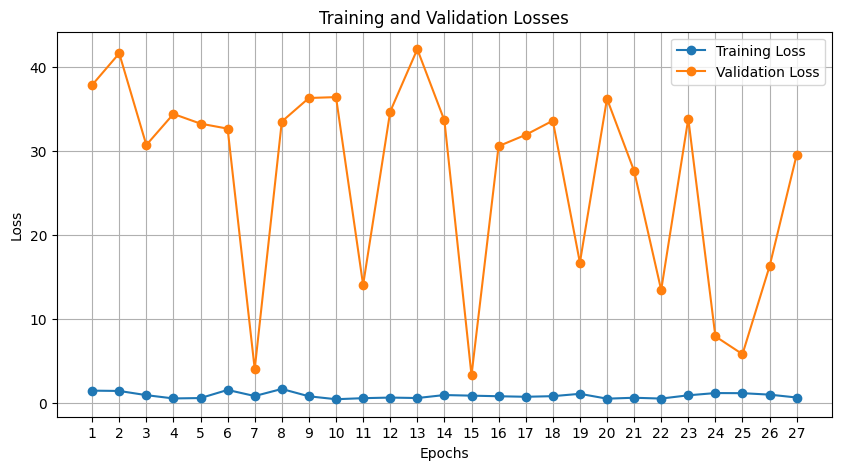

In [26]:
# Extracting training and validation losses
training_losses = torch.tensor(hist[0]).numpy().flatten()
validation_losses = torch.tensor(hist[1]).numpy().flatten()

# Get the minimum length to avoid the ValueError
min_length = min(len(training_losses), len(validation_losses))

# Trim both lists to the minimum length
training_losses_trimmed = training_losses[:min_length]
validation_losses_trimmed = validation_losses[:min_length]

# Number of epochs (should match the trimmed lists)
epochs = range(1, min_length + 1)

# Create a line plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses_trimmed, marker='o', linestyle='-', label='Training Loss')
plt.plot(epochs, validation_losses_trimmed, marker='o', linestyle='-', label='Validation Loss')

# Adding titles and labels
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(epochs)  # Set x-ticks to match the epochs
plt.show()

#### Basic beep indicating training is done

In [27]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

#### Saving the weights

In [28]:
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [29]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 256, kernel_size=(2, 2), stride=(2, 2))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (query): Linear(in_features=256, out_features=128, bias=True)
            (key): Linear(in_features=256, out_features=128, bias=True)
            (value): Linear(in_features=256, out_features=128, bias=True)
          )
        )
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
 

## Prediction

- This is the same method used in the validation but it stores predicted data to be visualized 
- Comment and uncomment lines to print different parts like 
- The Microbleed that is shown on the full MRI image 
- The 16x16 patch to see the mask output

In [30]:
def predict(model, image, mask):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(images = image, mask = mask)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [31]:
for i, data in enumerate(val_loader):
    print(data)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [32]:
val_loss = 0.0
length = len(val_loader)
case = 0 
predictions = []
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(val_loader, 0)):
        num_slices = len(val_batch[1])#Number of slces
        one_case = []#This is where we store every slice of the case 
        case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
        one_case.append(case_number)
        slice_list = []

        # slices_images = [] #This is where we store the images of the slices
        # slices_predictions = [] #This is where we store the predictions of the slices
        # slices_true_labels = [] #This is where we store the true labels of the slices

        print(f'Case: {case_number}')
        if num_slices != len(val_batch[0]):
            print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
            break
        for j in range(num_slices):
            prediction_data = []#This is where we store the data of the slice predictions that will be appended to the slices_predictions list
            slice_data = []
            bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
            cropped_images = []
            cropped_labels = []
            coordinates = []
            if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                print('No bounding boxes found on slice ', j)
                
                for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                    print(f"Slice {j} | ", bbox)
                    print(val_batch[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = val_batch[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = val_batch[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break
                # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                # print('Cropped Images length:', len(cropped_images))
                # print('Cropped Labels length:', len(cropped_labels))
                # print('Cropped Images number of slices:', len(cropped_images[0][0][0]))
                # print('Cropped Labels number of slices:', len(cropped_labels[0][0]))
                for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                    for l, cmb_slice in enumerate(cmb):
                        if torch.unique(cmb_slice).numel() > 1:
                            one_cmb = []
                            # print('Predicting CMB with coordinates: ', coordinates[k])
                            # print(cmb_slice.shape)
                            # print(cropped_images[0][0][0][l].shape)
                            
                            # Enable ths method to visually see what is feeded on the model
                            # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            # print("Feeded inputs shape: ",inputs.shape)
                            # print("Feeded mask shape: ",labels.shape)
                            predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float())
                            # print("Output shape: ",predicted_mask.shape)

                            one_cmb.append(predicted_mask[0])
                            one_cmb.append(cmb_slice)
                            one_cmb.append(coordinates[k])
                            prediction_data.append(one_cmb)
                            # print_image(predicted_mask[0], f'Predicted Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Ground Truth Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')

            slice_data.append(j)
            slice_data.append(val_batch[0][j][0])
            slice_data.append(prediction_data)
            slice_data.append(val_batch[1][j][0])
            slice_list.append(slice_data)
            
            print("image shape append: ", val_batch[0][j].shape)
        # print("Images", slices_images)
        # print("Appended images: ", len(slices_images))

        one_case.append(slice_list)
        predictions.append(one_case)



0it [00:00, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 110
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  11
Slice 11 |  [151, 359, 155, 362]
torch.Size([1, 512, 512])
Slice 11 |  [111, 210, 115, 214]
torch.Size([1, 512, 512])
Slice 11 |  [165, 159, 170, 164]
torch.Size([1, 512, 512])
Predicting on Case 110 Slice 11 CMB coordinates [151, 359, 155, 362]
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No boun

1it [00:00,  1.43it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Predicting on Case 110 Slice 30 CMB coordinates [172, 221, 179, 227]
Predicting on Case 110 Slice 31 CMB coordinates [172, 221, 179, 227]
Predicting on Case 110 Slice 32 CMB coordinates [172, 221, 179, 227]
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])


2it [00:01,  2.03it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 107
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  13
Slice 13 |  [154, 205, 157, 209]
torch.Size([1, 512, 512])
Predicting on Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torc

3it [00:01,  2.16it/s]

Case: 109
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

In [33]:
import torch
import matplotlib.pyplot as plt

def overlay_mask(image, mask, coordinates):
    x1, y1, x2, y2 = coordinates
    resized_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(y2-y1, x2-x1), mode='nearest').squeeze()

    mask_overlay = torch.zeros_like(image)
    mask_overlay[y1:y2, x1:x2] = resized_mask

    return image, mask_overlay

def show_image(image, mask_overlay, title):
    plt.imshow(image, cmap='gray') 
    plt.imshow(mask_overlay, cmap='hot', alpha=0.5)  
    plt.title(title)
    plt.axis('off')
    plt.show()


### Switch p for predicted and t for true mask

In [34]:
mask_type = 'p'
# mask_type = 't'

------------Case 110---------------
Length of the whole case:  2
Case number 110
Number of slices:  35
================Case 110 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 5

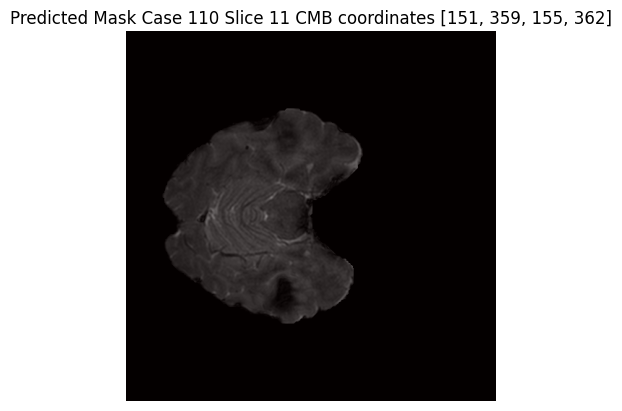

================Case 110 Slice 12================
Slice 12
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 13================
Slice 13
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [95, 235, 100, 239]


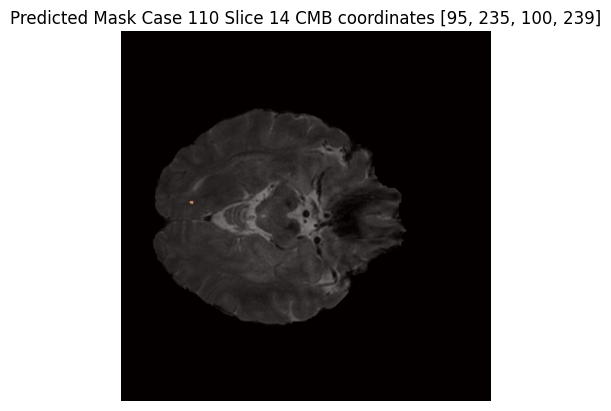

================Case 110 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [241, 309, 245, 313]


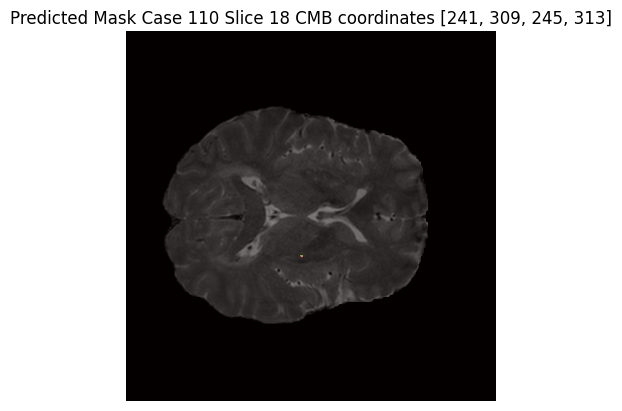

================Case 110 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


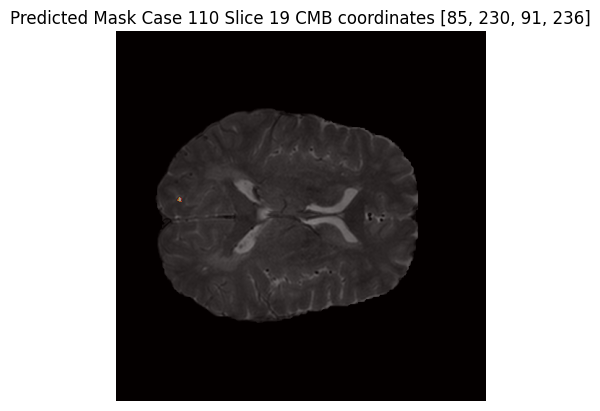

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


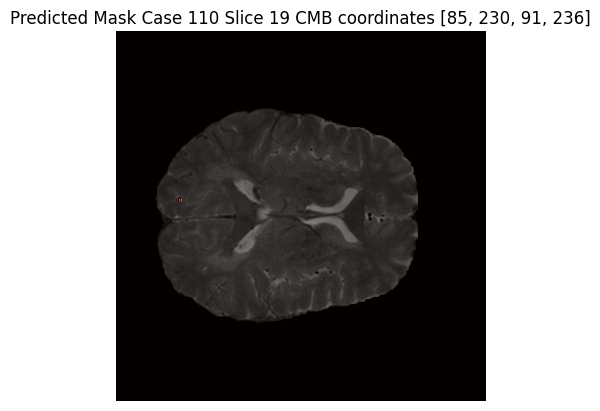

================Case 110 Slice 20================
Slice 20
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [93, 311, 97, 315]


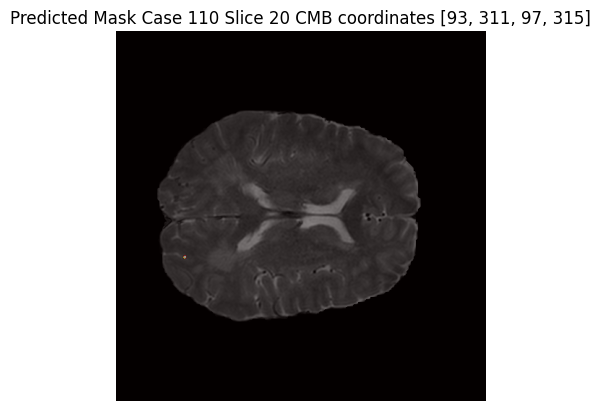

================Case 110 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [82, 312, 86, 316]


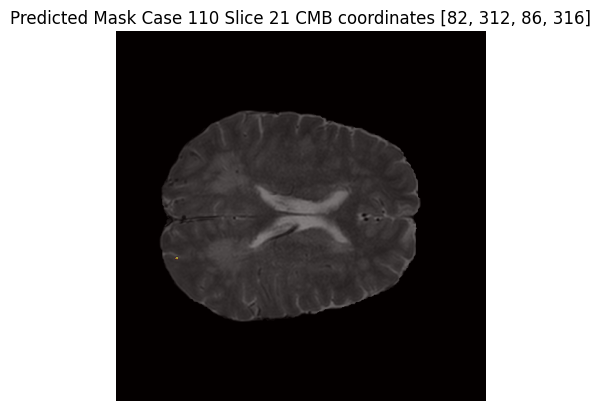

================Case 110 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


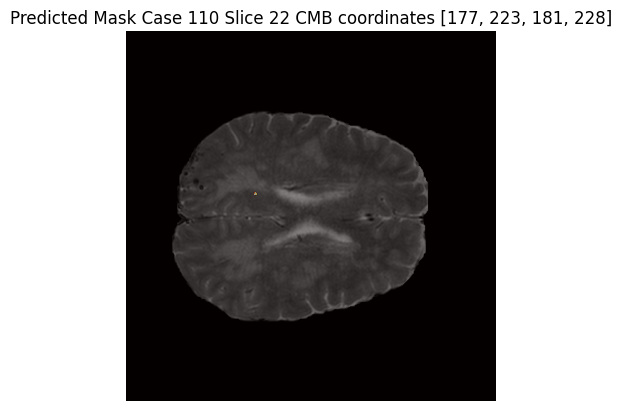

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


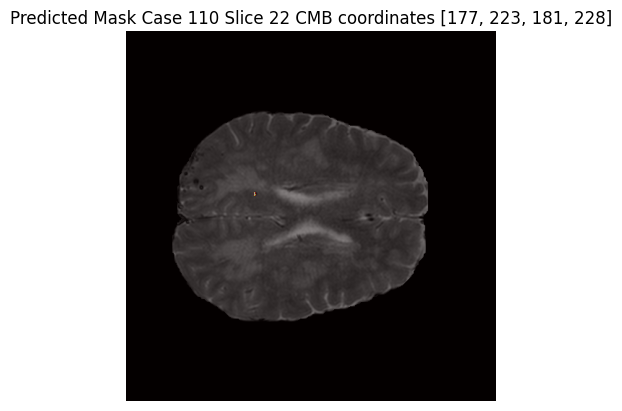

================Case 110 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [182, 234, 186, 239]


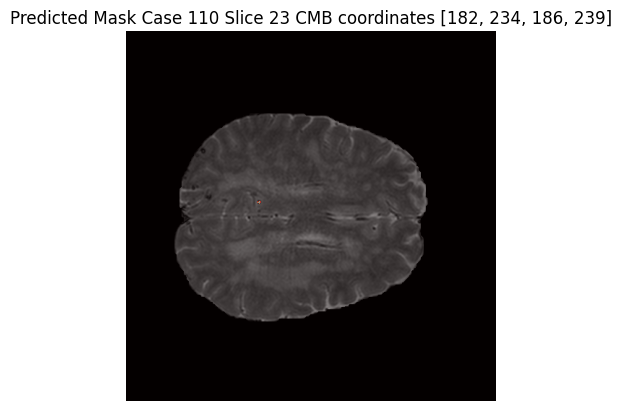

================Case 110 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [114, 247, 118, 251]


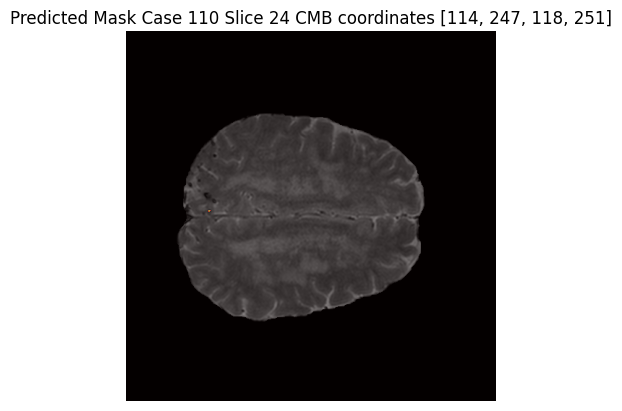

================Case 110 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [99, 321, 103, 325]


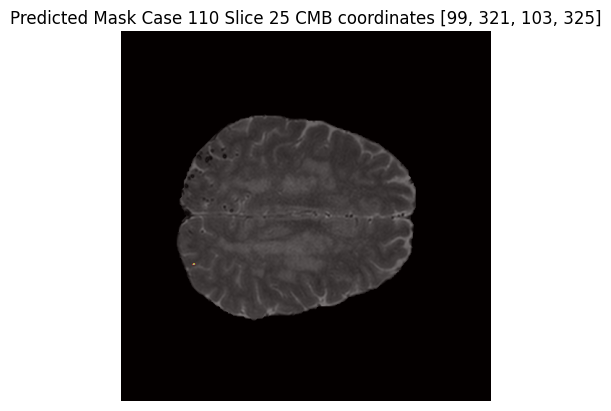

================Case 110 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


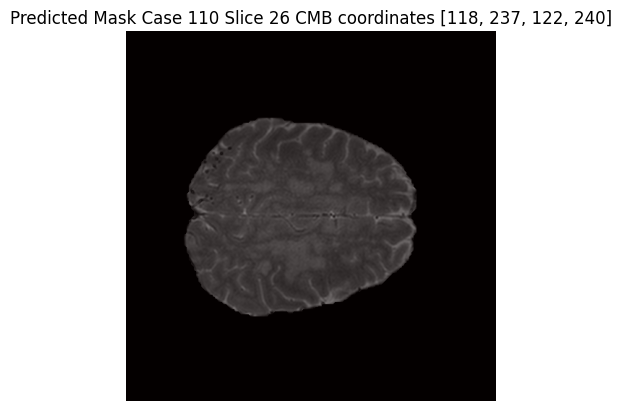

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


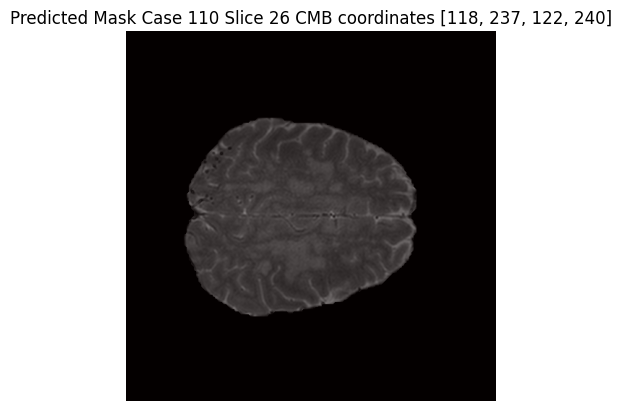

================Case 110 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [117, 297, 121, 302]


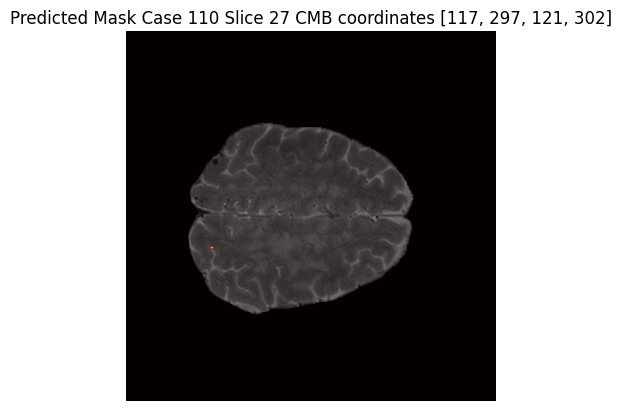

================Case 110 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [169, 245, 173, 249]


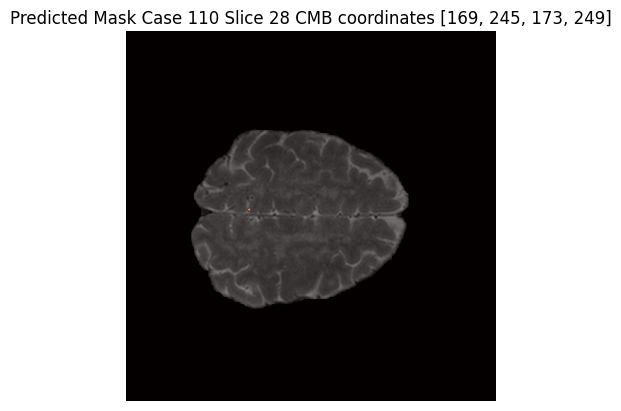

================Case 110 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


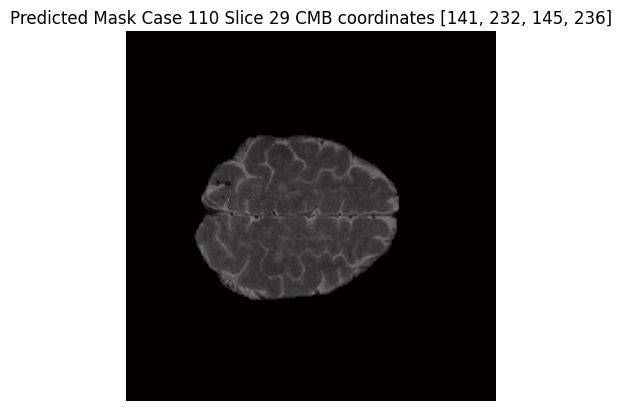

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


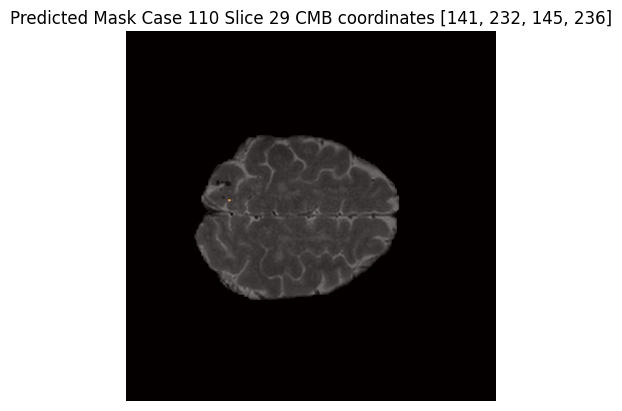

================Case 110 Slice 30================
Slice 30
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [150, 297, 154, 302]


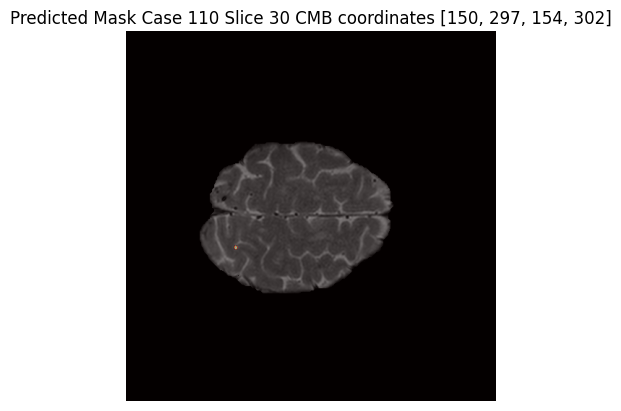

================Case 110 Slice 31================
Slice 31
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


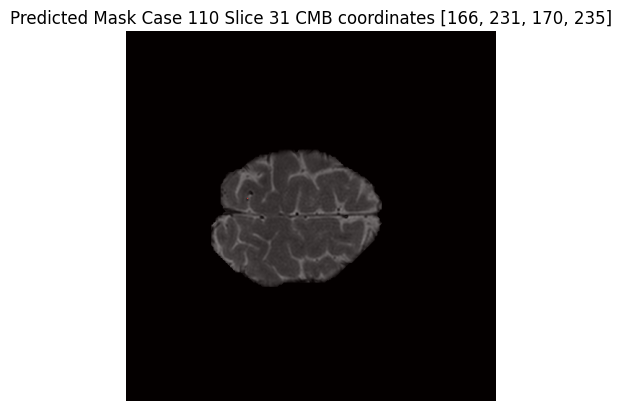

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


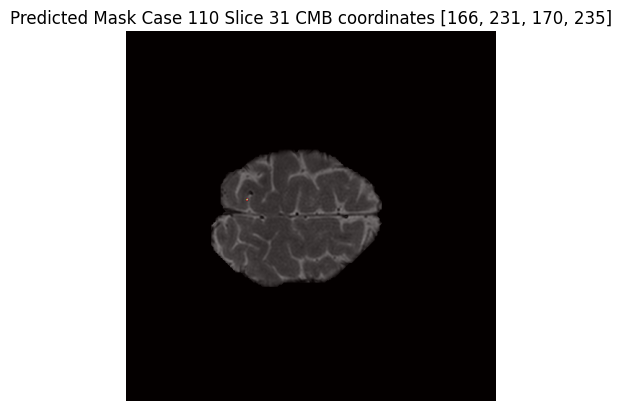

================Case 110 Slice 32================
Slice 32
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


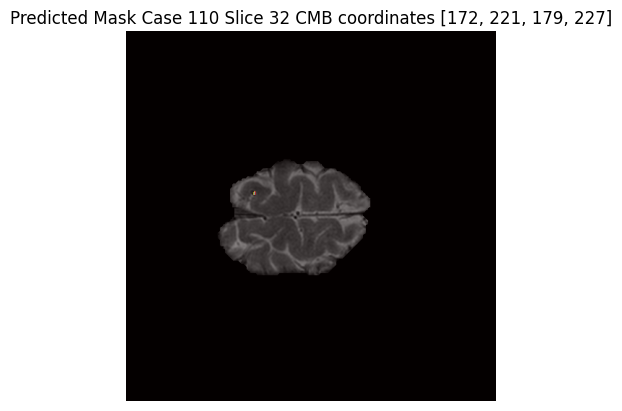

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


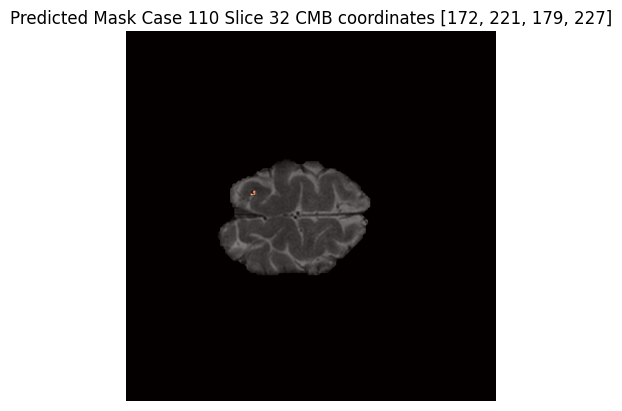

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


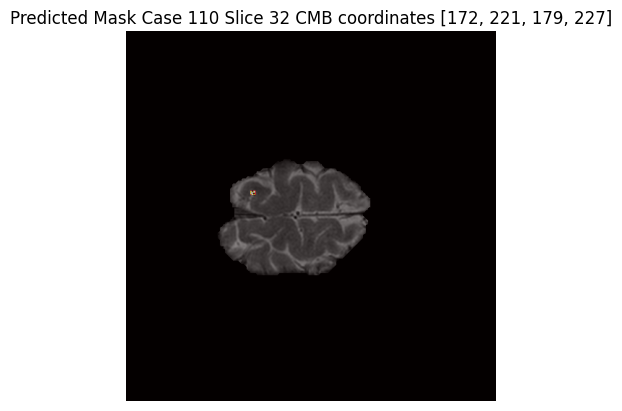

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


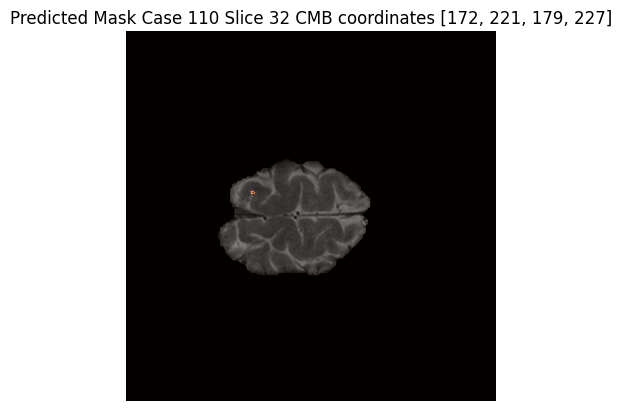

================Case 110 Slice 33================
Slice 33
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 34================
Slice 34
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
------------Case 107---------------
Length of the whole case:  2
Case number 107
Number of slices:  35
================Case 107 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 3================
Slice 3
Image shape:  torch.Size([1, 51

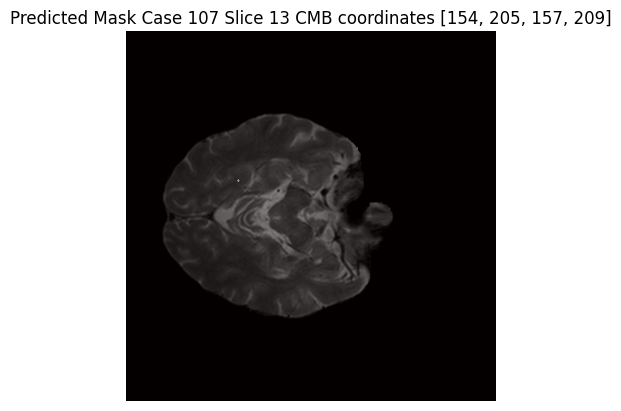

================Case 107 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

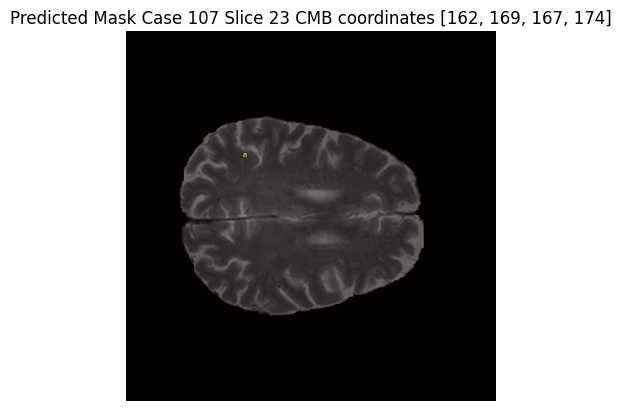

================Case 107 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

In [35]:
for case in predictions:
    case_number = case[0]
    print(f"------------Case {case_number}---------------")
    print("Length of the whole case: ", len(case))
    print("Case number", case[0])
    print("Number of slices: ", len(case[1]))

    for i, case_slice in enumerate(case[1]):
        slice_number = case_slice[0]
        print(f"================Case {case_number} Slice {slice_number}================")
        print(f"Slice {slice_number}")
        print("Image shape: ", case_slice[1].shape)
        print("Prediction length: ", len(case_slice[2]))
        print("True label shape: ", case_slice[3].shape)
        slice_image = case_slice[1][0]
        slice_prediction = case_slice[2]
        # Assuming your slice_prediction contains multiple masks
        for j, slice_pred in enumerate(slice_prediction):
            print(f"Prediction {j}")
            print("Predicted Mask shape: ", slice_pred[0].shape)
            print("True Mask shape: ", slice_pred[1].shape)
            print("Coordinates: ", slice_pred[2])
            
            predicted_mask = slice_pred[0]  
            true_mask = slice_pred[1]       
            coordinates = slice_pred[2]     
            

            predicted_mask = torch.tensor(predicted_mask, dtype=torch.float32)
            
   
            image_slice = slice_image
            
            
            if mask_type == 'p':
                image, mask_overlay = overlay_mask(image_slice, predicted_mask, coordinates)
                show_image(image, mask_overlay, f'Predicted Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            elif mask_type == 't':
                image, mask_overlay = overlay_mask(image_slice, true_mask, coordinates)
                show_image(image, mask_overlay, f'True Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            else:
                print("Invalid input! Skipping this slice.")
    # break

#### Whole process is completed

In [36]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
